Main question:
Understanding the role of primary visual cortex in decision making

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

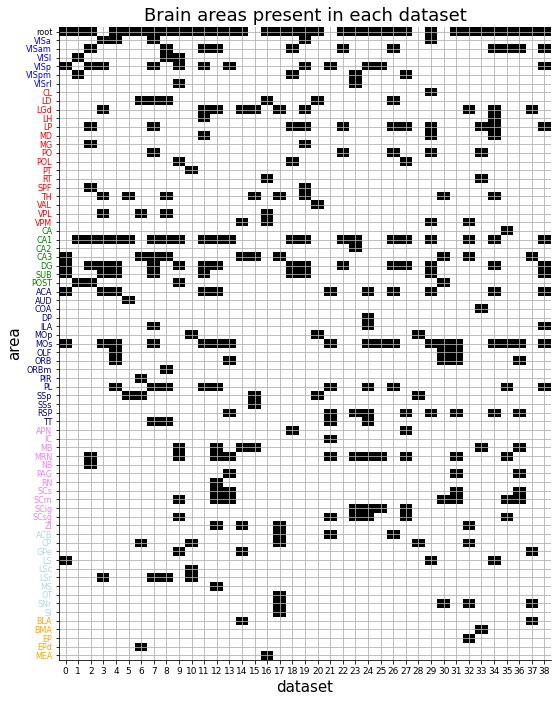

In [ ]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

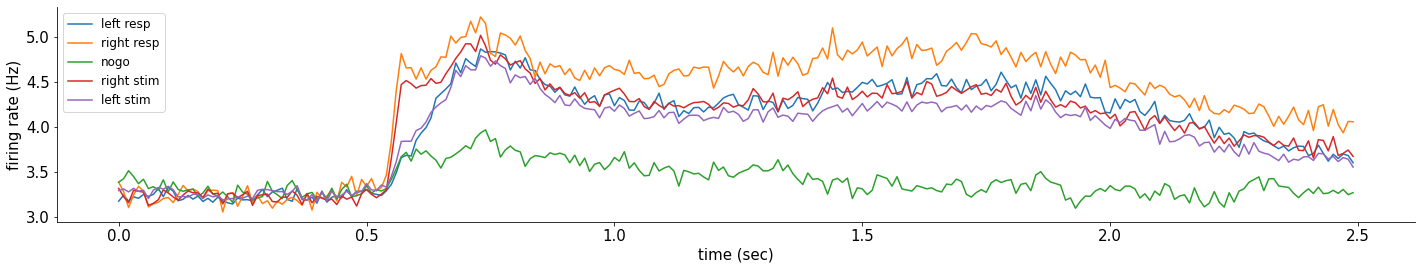

In [ ]:
dat = alldat[8]
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]
ax = plt.subplot(1, 1, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
wheel = dat['wheel']
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response == 0].mean(axis=(0, 1))) # nogo
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_left > 0].mean(axis=(0, 1)))  #  stimulus on the left
plt.legend(['left resp', 'right resp', 'nogo', 'right stim', 'left stim', 'wheel to left', 'wheel to right', 'no movement'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
NN = len(dat['brain_area'])  # number of neurons
barea = np.ones(NN, )  # last one is "other"
barea[np.isin(dat['brain_area'], brain_groups[0])] =  0

In [ ]:
spikes = dat['spks'][barea==0]

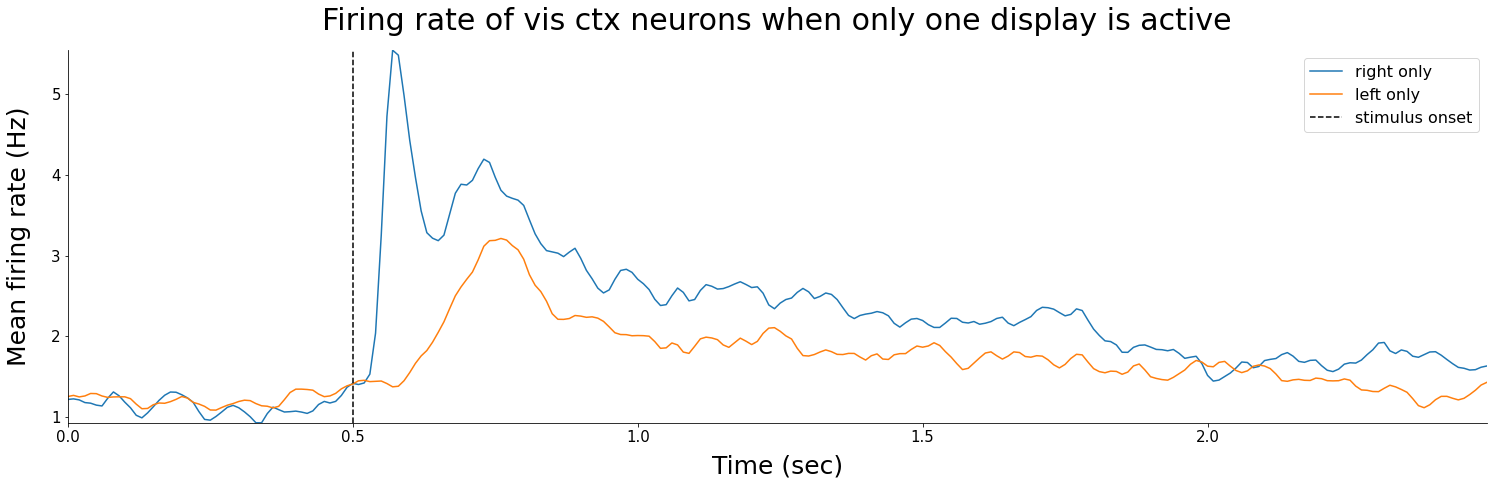

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(dt * np.arange(NT), gaussian_filter1d(1/dt * dat['spks'][barea==0][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(1/dt * dat['spks'][barea==0][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)),1))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
# plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][barea==0][:, response > 0].mean(axis=(0, 1)))
# plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][barea==0][:, response < 0].mean(axis=(0, 1)))
#plt.text(.3, .82, 'n=%d'%np.sum(barea == 0), transform=ax.transAxes)
plt.legend(['right only', 'left only', 'stimulus onset'], fontsize=16)
#plt.legend(['movement to left', 'movement to right'], fontsize=12)
#ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Mean firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Firing rate of vis ctx neurons when only one display is active', fontsize = 30, pad = 20)
plt.margins(0)

In [ ]:
cond = np.zeros(372)

In [ ]:
cond.shape

(372,)

In [ ]:
for i in range(372):
  if vis_right[i] == 1:
    if vis_left[i] == 1:
      cond[i] = 1
    if vis_left[i] == 0.5:
      cond[i] = 2
    if vis_left[i] == 0.25:
      cond[i] = 3
    if vis_left[i] == 0:
      cond[i] = 4
  if vis_right[i] == 0.5:
    if vis_left[i] == 1:
      cond[i] = 5
    if vis_left[i] == 0.5:
      cond[i] = 6
    if vis_left[i] == 0.25:
      cond[i] = 7
    if vis_left[i] == 0:
      cond[i] = 8
  if vis_right[i] == 0.25:
    if vis_left[i] == 1:
      cond[i] = 9
    if vis_left[i] == 0.5:
      cond[i] = 10
    if vis_left[i] == 0.25:
      cond[i] = 11
    if vis_left[i] == 0:
      cond[i] = 12
  if vis_right[i] == 0:
    if vis_left[i] == 1:
      cond[i] = 13
    if vis_left[i] == 0.5:
      cond[i] = 14
    if vis_left[i] == 0.25:
      cond[i] = 15
    if vis_left[i] == 0:
      cond[i] = 16

In [ ]:
cond

array([ 9., 13., 14.,  5., 13.,  9., 12.,  9., 11., 13.,  4., 14., 14.,
       14., 13., 14., 14., 10.,  4., 15., 14., 14., 13., 14.,  3., 14.,
       12., 16., 16., 16., 16., 15.,  9.,  5., 14., 10.,  9.,  1.,  8.,
        8.,  7., 16., 12.,  8., 10.,  3.,  4., 13., 16.,  9.,  5.,  8.,
       14., 11., 16., 16.,  7., 14., 13., 13., 16., 13., 14.,  4., 13.,
       14., 16.,  8., 16., 16., 16.,  5., 13., 13., 13., 13.,  9.,  8.,
        7., 12., 15.,  9., 14., 12.,  9., 16., 14., 14.,  9.,  9.,  9.,
        9.,  9.,  9., 16., 15., 14., 14., 13., 13.,  8.,  1., 14., 14.,
       13., 13., 13., 15., 16.,  7., 14., 16., 14., 11., 14., 14.,  9.,
        9., 16.,  6., 13., 16., 12., 16., 14., 16., 14.,  1.,  8., 12.,
        9.,  9.,  8., 15.,  7., 13.,  2., 16., 16.,  5., 16., 16., 14.,
       14.,  8., 11., 12., 13., 13., 13., 16.,  4.,  4.,  3.,  3.,  9.,
        9.,  9., 16., 13.,  8.,  4.,  9., 14., 13., 14., 13., 13., 16.,
       16., 16.,  4.,  2.,  2., 13., 11.,  8., 13.,  9.,  4.,  3

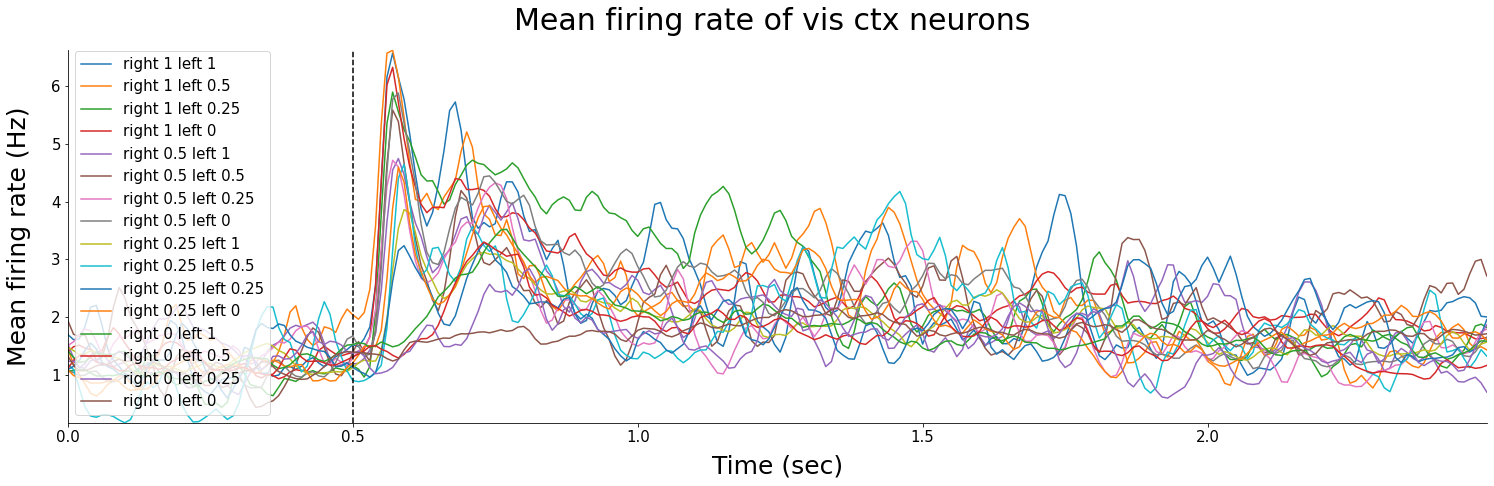

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 1, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 2, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 3, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 4, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 5, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 6, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 7, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 8, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 9, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 10, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 11, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 12, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 13, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 14, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 15, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, cond == 16, :], axis =(0,1)),1))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['right 1 left 1', 'right 1 left 0.5', 'right 1 left 0.25', 'right 1 left 0', 'right 0.5 left 1', 'right 0.5 left 0.5', 'right 0.5 left 0.25', 'right 0.5 left 0', 'right 0.25 left 1', 'right 0.25 left 0.5', 'right 0.25 left 0.25', 'right 0.25 left 0', 'right 0 left 1', 'right 0 left 0.5', 'right 0 left 0.25', 'right 0 left 0'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Mean firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Mean firing rate of vis ctx neurons ', fontsize = 30, pad = 20)
plt.margins(0)

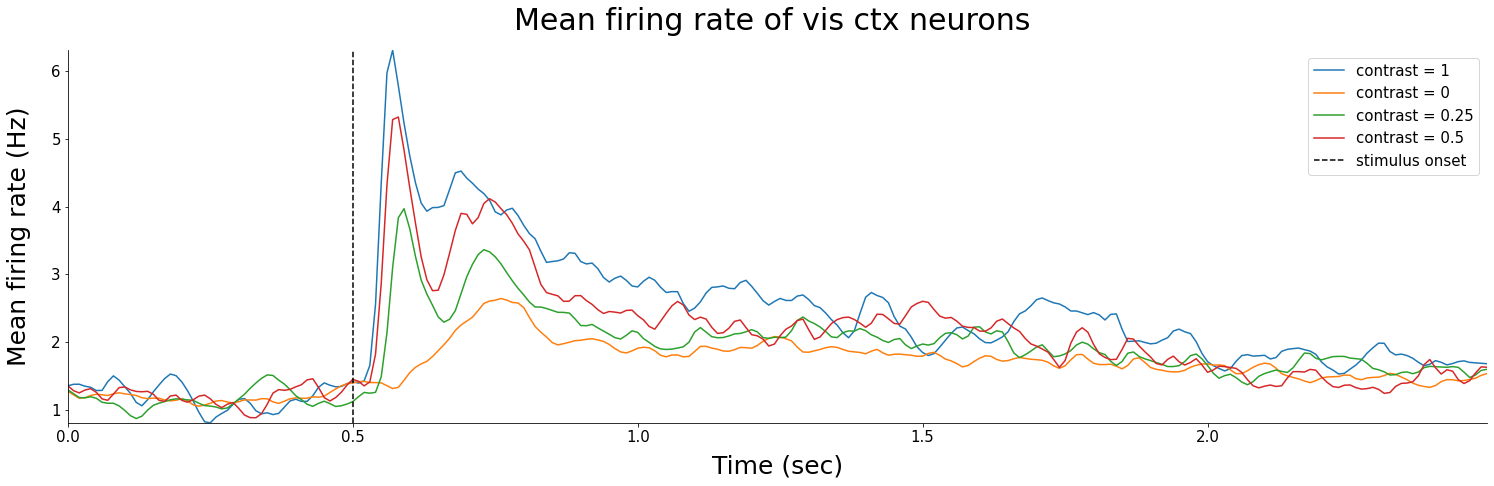

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, vis_right == 1, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, vis_right == 0, :],  axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[:, vis_right == 0.25, :], axis =(0,1)),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean( 1/dt *spikes[:, vis_right == 0.5, :], axis =(0,1)),1))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['contrast = 1', 'contrast = 0', 'contrast = 0.25', 'contrast = 0.5', 'stimulus onset'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Mean firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Mean firing rate of vis ctx neurons ', fontsize = 30, pad = 20)
plt.margins(0)

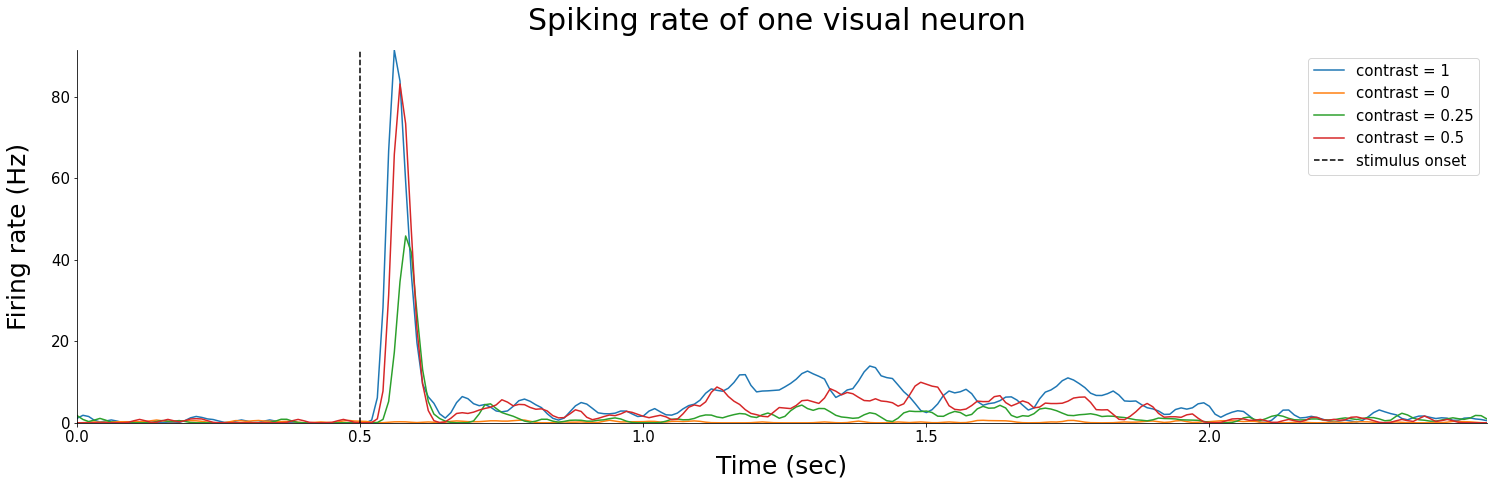

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[0, vis_right == 1, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[0, vis_right == 0, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[0, vis_right == 0.25, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean( 1/dt *spikes[0, vis_right == 0.5, :], axis =0),1))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['contrast = 1', 'contrast = 0', 'contrast = 0.25', 'contrast = 0.5', 'stimulus onset'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Spiking rate of one visual neuron ', fontsize = 30, pad = 20)
plt.margins(0)

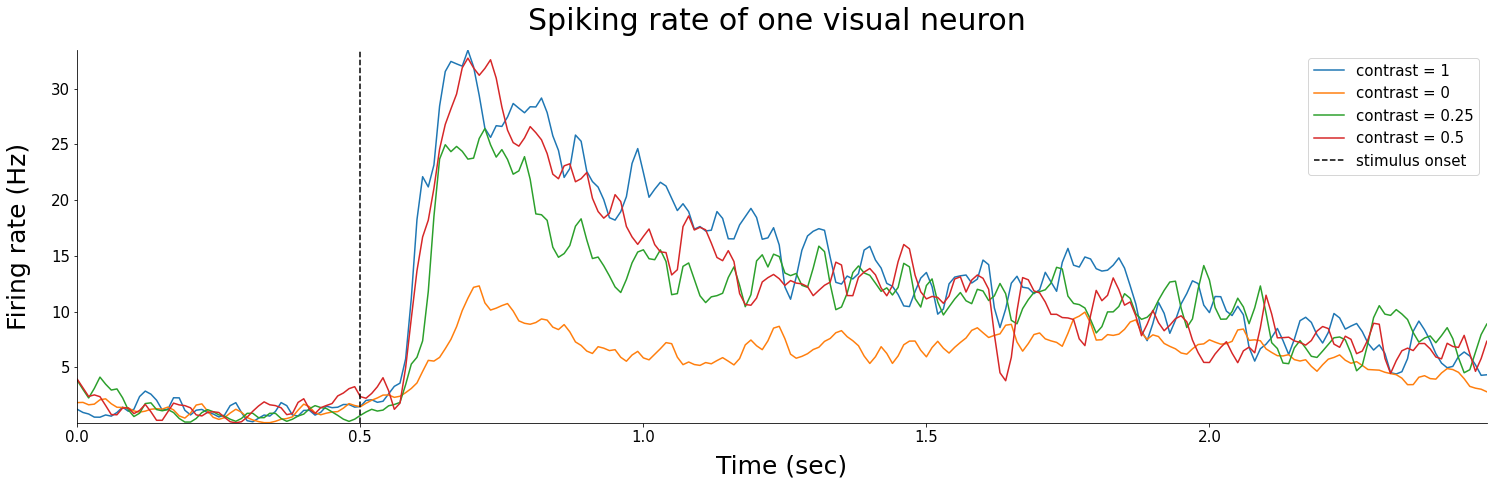

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[137, vis_right == 1, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[137, vis_right == 0, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean(1/dt * spikes[137, vis_right == 0.25, :], axis =0),1))
plt.plot(dt * np.arange(NT), gaussian_filter1d(np.mean( 1/dt *spikes[137, vis_right == 0.5, :], axis =0),1))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['contrast = 1', 'contrast = 0', 'contrast = 0.25', 'contrast = 0.5', 'stimulus onset'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Spiking rate of one decision neuron ', fontsize = 30, pad = 20)
plt.margins(0)

In [ ]:
step = 1
win = 5
t = dt * np.arange(NT)

In [ ]:
Z = dat['spks'][barea==0]
neurons = len(Z)
trials = Z.shape[1]

In [ ]:
windowed_spikes = []
for i in range(0, 250, step):
  windowed_spikes.append(Z[:, :, i:i+win].mean(axis=2))
windowed_spikes = np.array(windowed_spikes)
windowed_spikes = windowed_spikes.transpose()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
x = windowed_spikes

In [ ]:
mutual_info = []
for i in range(neurons):
  mutual_info.append(mutual_info_regression(x[:, i, :], vis_right))
mutual_info = np.array(mutual_info)

In [ ]:
mi_pair = []
for i in range(neurons):
  mi_pair.append(mutual_info_regression(x[:, i, :], cond))
mi_pair = np.array(mi_pair)

In [ ]:
mi_pair

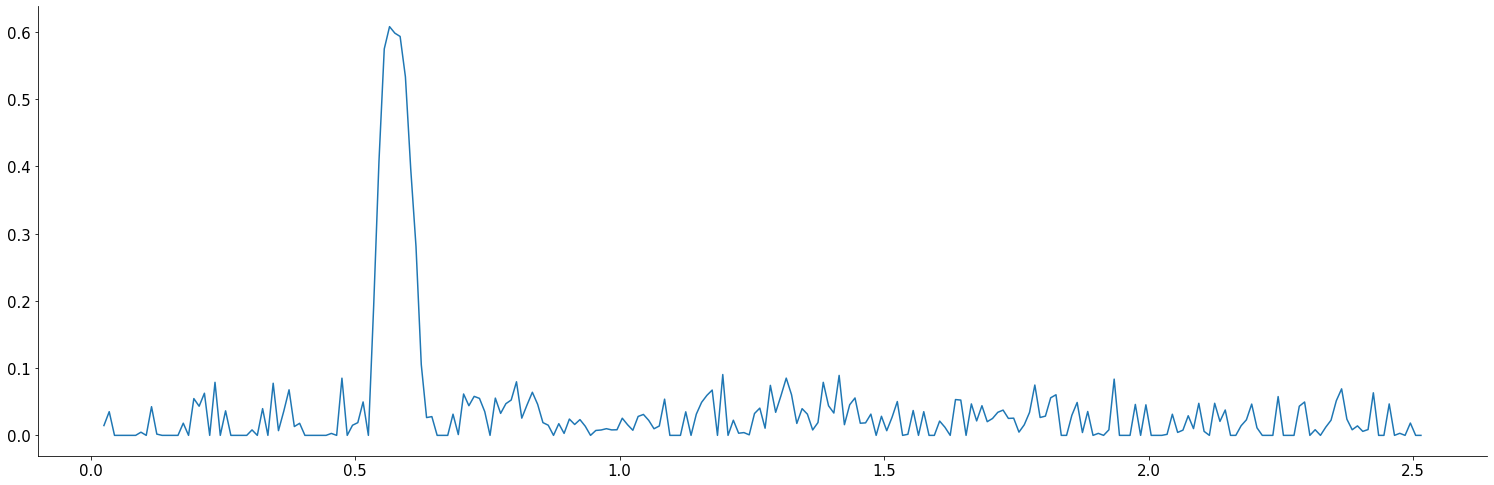

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(t+0.025, mi_pair[0])

In [ ]:
mi_left = []
for i in range(neurons):
  mi_left.append(mutual_info_regression(x[:, i, :], vis_left))
mi_left = np.array(mi_left)

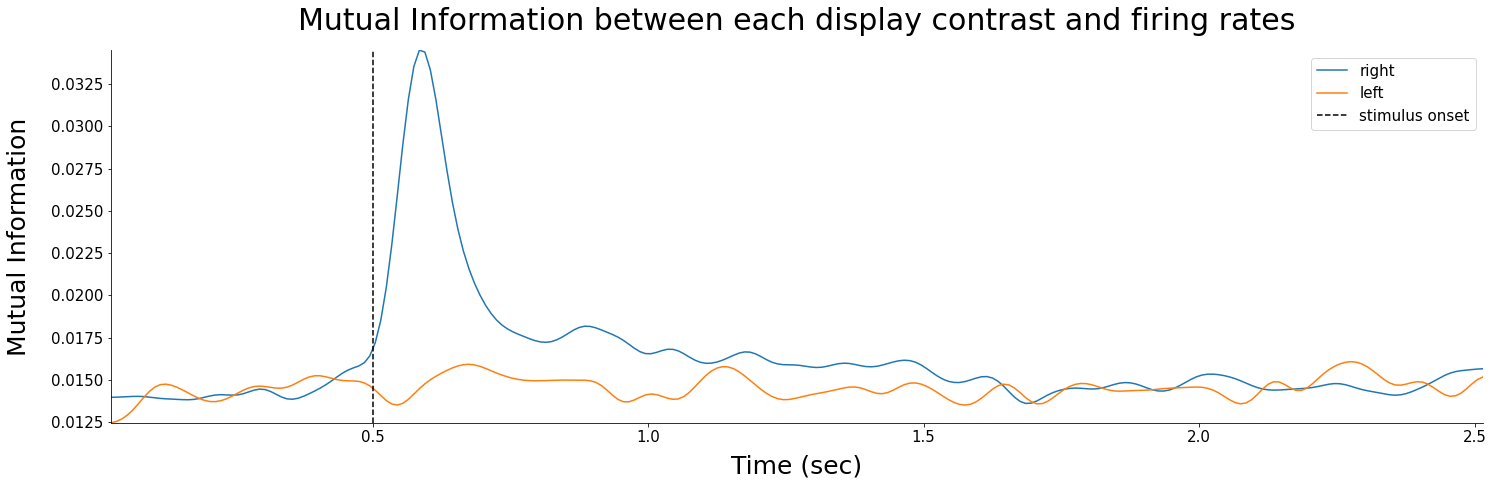

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(t+0.025, gaussian_filter1d(np.mean(mutual_info, axis = 0),3))
plt.plot(t+0.025, gaussian_filter1d(np.mean(mi_left, axis = 0),3))
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['right', 'left', 'stimulus onset'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Mutual Information', fontsize = 25, labelpad = 20)
plt.title('Mutual Information between each display contrast and firing rates', fontsize = 30, pad = 20)
plt.margins(0)

In [ ]:
mi_response = []
for i in range(neurons):
  mi_response.append(mutual_info_regression(x[:, i, :], response))

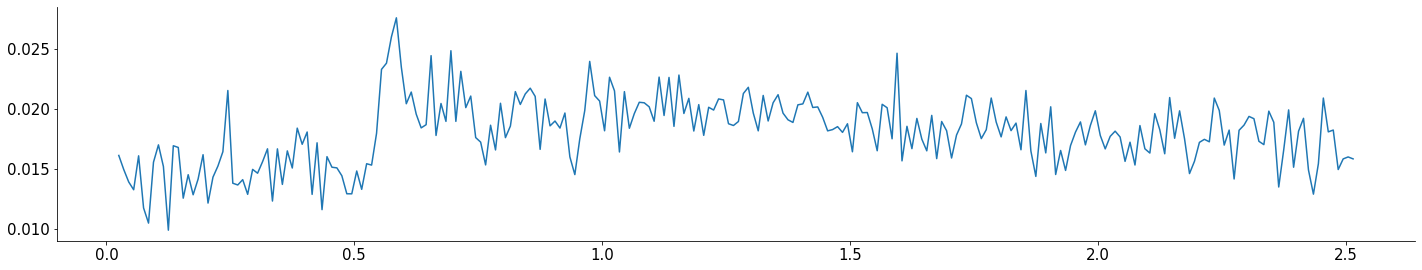

In [ ]:
plt.plot(t+0.025, np.mean(mi_response, axis = 0))

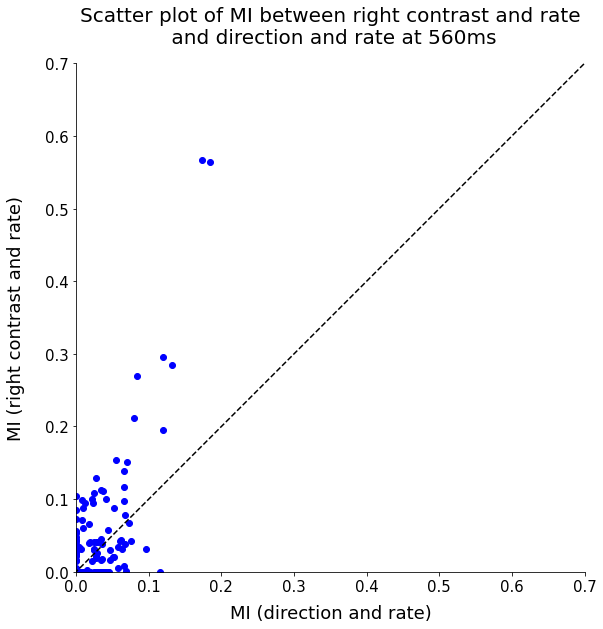

In [ ]:
ax = plt.subplots(figsize=(9, 9))
for i in range(neurons):
  plt.scatter(mi_response[i][56], mutual_info[i][56], color = 'b')
a, b = (1), 0.0
l = np.linspace(-1, 1, 100)
plt.axis('square')
plt.xlim(0, 0.7)
plt.ylim(0, 0.7)
plt.plot(l, l*a+b, color='k', linestyle='--')
plt.xlabel('MI (direction and rate)', fontsize = 18, labelpad = 10)
plt.ylabel('MI (right contrast and rate)', fontsize = 18, labelpad = 20)
plt.title('Scatter plot of MI between right contrast and rate\n and direction and rate at 560ms', fontsize = 20, pad = 20)
plt.margins(0)

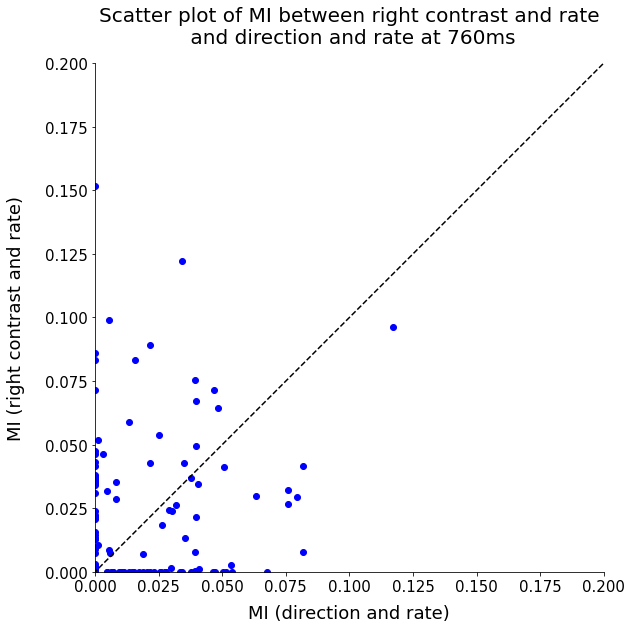

In [ ]:
ax = plt.subplots(figsize=(9, 9))
for i in range(neurons):
  plt.scatter(mi_response[i][76], mutual_info[i][76], color = 'b')
a, b = (1), 0.0
l = np.linspace(-1, 1, 100)
plt.axis('square')
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.plot(l, l*a+b, color='k', linestyle='--')
#ax.set(xlabel='MI (response)', ylabel='MI (stim)', title='scatter plot of MI at 760ms')
plt.xlabel('MI (direction and rate)', fontsize = 18, labelpad = 10)
plt.ylabel('MI (right contrast and rate)', fontsize = 18, labelpad = 20)
plt.title('Scatter plot of MI between right contrast and rate\n and direction and rate at 760ms', fontsize = 20, pad = 20)
plt.margins(0)

In [ ]:
decision_neurons = []
for i in range(neurons):
  if mi_response[i][76] > mutual_info[i][76]:
    decision_neurons.append(spikes[i])
decision_neurons = np.array(decision_neurons)

In [ ]:
decision_n = []
for i in range(neurons):
  if mi_response[i][76] > 0.1:
    decision_n.append(i)
decision_n = np.array(decision_n)

In [ ]:
decision_n

array([137])

Text(0.5, 1.0, 'Scatter plot of MI between right contrast and rate\n and direction and rate at 560ms')

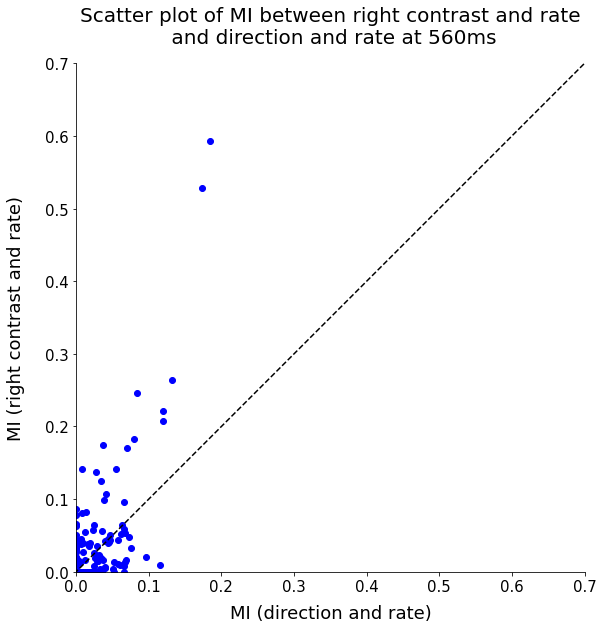

In [ ]:
ax = plt.subplots(figsize=(9, 9))
for i in range(neurons):
  plt.scatter(mi_response[i][56], mi_pair[i][56], color = 'b')
a, b = (1), 0.0
l = np.linspace(-1, 1, 100)
plt.axis('square')
plt.xlim(0, 0.7)
plt.ylim(0, 0.7)
plt.plot(l, l*a+b, color='k', linestyle='--')
plt.xlabel('MI (direction and rate)', fontsize = 18, labelpad = 10)
plt.ylabel('MI (right contrast and rate)', fontsize = 18, labelpad = 20)
plt.title('Scatter plot of MI between right contrast and rate\n and direction and rate at 560ms', fontsize = 20, pad = 20)

In [ ]:
visual_neurons = []
for i in range(neurons):
  if mi_response[i][56] < mutual_info[i][56]:
    visual_neurons.append(spikes[i])
visual_neurons = np.array(visual_neurons)

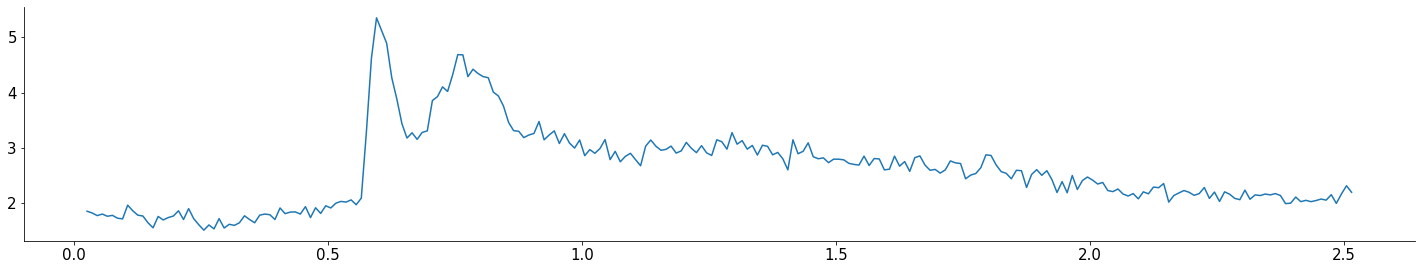

In [ ]:

y3 = 1/dt * visual_neurons.mean(axis=(0, 1))
plt.plot(t+0.025, y3)

In [ ]:
decision_neurons.shape

(54, 372, 250)

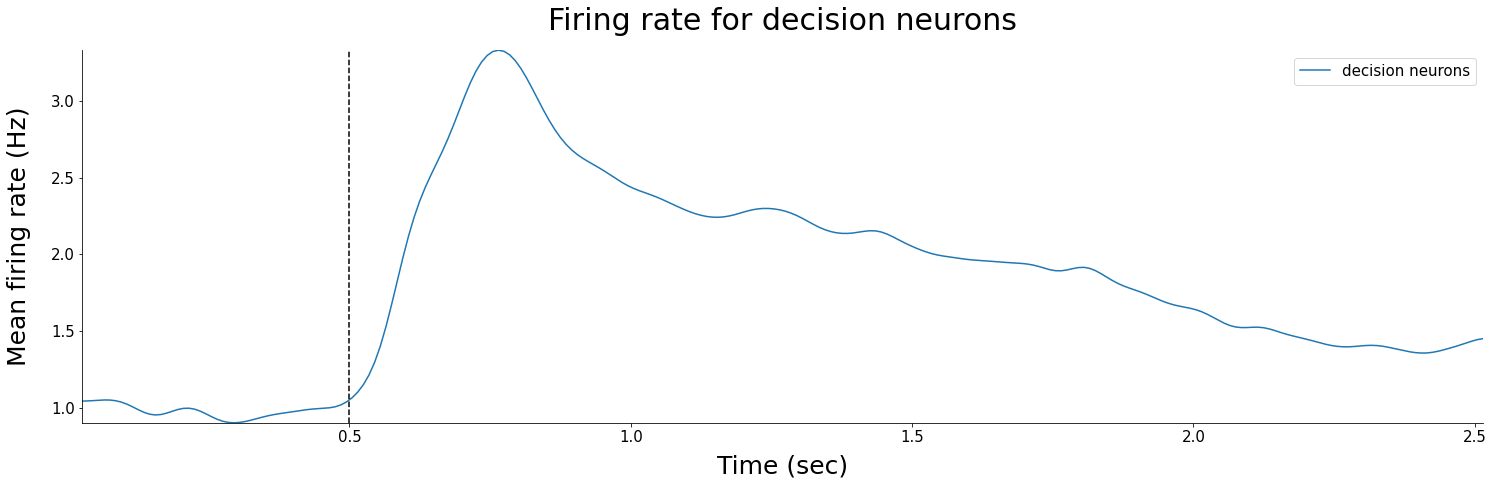

In [ ]:
ax = plt.subplots(figsize=(21, 7))
y3 = gaussian_filter1d(1/dt * decision_neurons.mean(axis=(0, 1)), 3)
plt.plot(t+0.025, y3)
#plt.plot(t+0.025, 1/dt * decision_neurons.mean(axis=(0, 1)))
# plt.axvline(x = 0.5, color = 'r', label = 'axvline - full height')
plt.legend(['decision neurons with gaussian filter', 'decision neurons' ])
# ax.set(xlabel='time (s)', ylabel='mean firing rate (Hz)', title='Spiking rate for decision neurons')
plt.axvline(x = 0.5, color = 'k', linestyle='--', label = 'axvline - full height')
plt.legend(['decision neurons'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Mean firing rate (Hz)', fontsize = 25, labelpad = 20)
plt.title('Firing rate for decision neurons', fontsize = 30, pad = 20)
plt.margins(0)

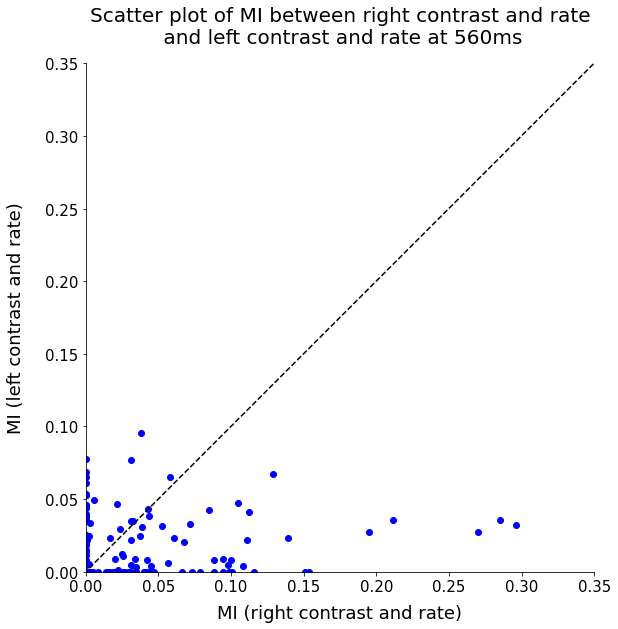

In [ ]:
ax = plt.subplots(figsize=(9, 9))
for i in range(neurons):
  plt.scatter(mutual_info[i][56], mi_left[i][56], color = 'b')
a, b = (1), 0.0
l = np.linspace(-1, 1, 100)
plt.axis('square')
plt.xlim(0, 0.35)
plt.ylim(0, 0.35)
plt.plot(l, l*a+b, color='k', linestyle='--')
#ax.set(xlabel='MI (right)', ylabel='MI (left)', title='scatter plot of MI at 560ms')
plt.xlabel('MI (right contrast and rate)', fontsize = 18, labelpad = 10)
plt.ylabel('MI (left contrast and rate)', fontsize = 18, labelpad = 20)
plt.title('Scatter plot of MI between right contrast and rate\n and left contrast and rate at 560ms', fontsize = 20, pad = 20)
plt.margins(0)

In [ ]:
left_neurons = []
for i in range(neurons):
  if mi_left[i][56] > mutual_info[i][56]:
    left_neurons.append(spikes[i])
left_neurons = np.array(left_neurons)

In [ ]:
left_neurons.shape

(41, 372, 250)

[Text(0, 0.5, 'mean firing rate (Hz)'), Text(0.5, 0, 'time (s)')]

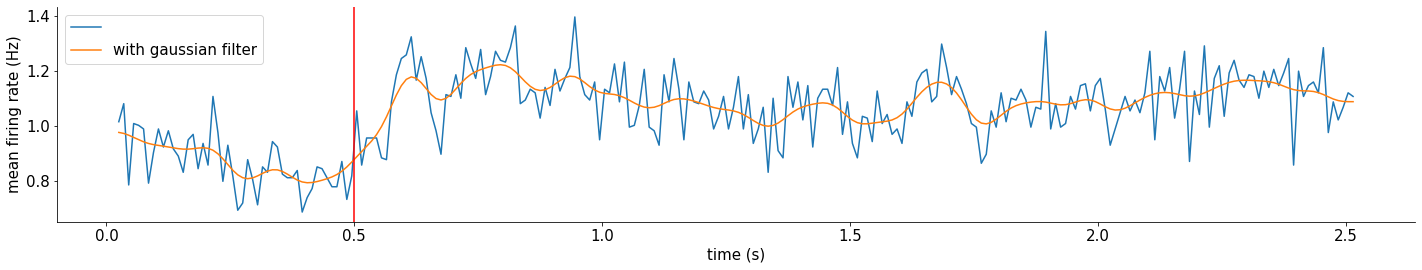

In [ ]:
ax = plt.subplot(1, 1, 1)
plt.plot(t+0.025, 1/dt * left_neurons.mean(axis=(0, 1)))
y3 = gaussian_filter1d(1/dt * left_neurons.mean(axis=(0, 1)), 3)
plt.plot(t+0.025, y3)
plt.axvline(x = 0.5, color = 'r', label = 'axvline - full height')
plt.legend(['', 'with gaussian filter' ])
ax.set(xlabel='time (s)', ylabel='mean firing rate (Hz)')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from scipy import stats

In [ ]:
y = vis_right
x = windowed_spikes
x_res = np.zeros((192, 142, 250))
acc_right = np.zeros((200,250))
scalers = {}
for i in range(x.shape[1]):
    scalers[i] = StandardScaler()
    x[:, i, :] = scalers[i].fit_transform(x[:, i, :])
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
for j in range(200):
  rus = RandomUnderSampler(random_state=j)
  for i in range(x.shape[1]):
    x_res[:, i, :], y = rus.fit_resample(x[:, i, :], y_transformed)
  X_train, X_test, y_train, y_test = train_test_split(x_res, y, test_size = 0.1, random_state=j, stratify=y)
  for i in range(X_train.shape[2]):
    svm = SVC(kernel='rbf', decision_function_shape ='ovo')
    svm = svm.fit(X_train[:, :, i], y_train)
    y_pred = svm.predict(X_test[:, :, i])
    acc_right[j, i] = accuracy_score(y_test, y_pred)

In [ ]:
mean_right = np.mean(acc_right, axis = 0)
std_right = np.std(acc_right, axis = 0)
sem_right = stats.sem(acc_right)

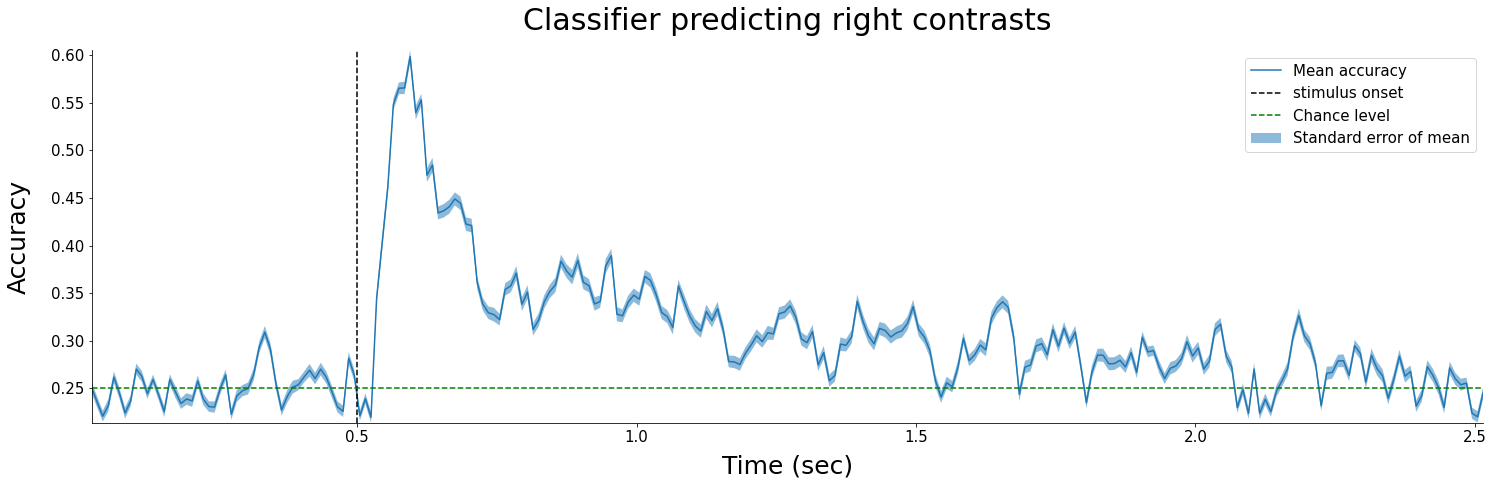

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(t+0.025, mean_right)
#ax.fill_between(t+0.025, (mean_right - std_right), (mean_right + std_right), alpha=.5, linewidth=0)
plt.fill_between(t+0.025, (mean_right - sem_right), (mean_right + sem_right), alpha=.5, linewidth=0)
plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
plt.axhline(y = 0.25, color = 'g', linestyle = '--', label = 'axhline - full height')
#ax.set(ylabel='Accuracy', xlabel='time (s)', title='Classifier predicting contrast on right display')
plt.legend(['Mean accuracy', 'stimulus onset', 'Chance level', 'Standard error of mean'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Accuracy', fontsize = 25, labelpad = 20)
plt.title('Classifier predicting right contrasts', fontsize = 30, pad = 20)
plt.margins(0)

In [ ]:
y = vis_left
x = windowed_spikes
x_res = np.zeros((180, 142, 250))
acc_left = np.zeros((200,250))
scalers = {}
for i in range(x.shape[1]):
    scalers[i] = StandardScaler()
    x[:, i, :] = scalers[i].fit_transform(x[:, i, :])
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
for j in range(200):
  rus = RandomUnderSampler(random_state=j)
  for i in range(x.shape[1]):
    x_res[:, i, :], y = rus.fit_resample(x[:, i, :], y_transformed)
  X_train, X_test, y_train, y_test = train_test_split(x_res, y, test_size = 0.1, random_state=j, stratify=y)
  for i in range(X_train.shape[2]):
    svm_left = SVC(kernel='rbf', decision_function_shape ='ovo')
    svm_left = svm_left.fit(X_train[:, :, i], y_train)
    y_pred = svm_left.predict(X_test[:, :, i])
    acc_left[j, i] = accuracy_score(y_test, y_pred)

In [ ]:
mean_left = np.mean(acc_left, axis = 0)
std_left = np.std(acc_left, axis = 0)
sem_left = stats.sem(acc_left)

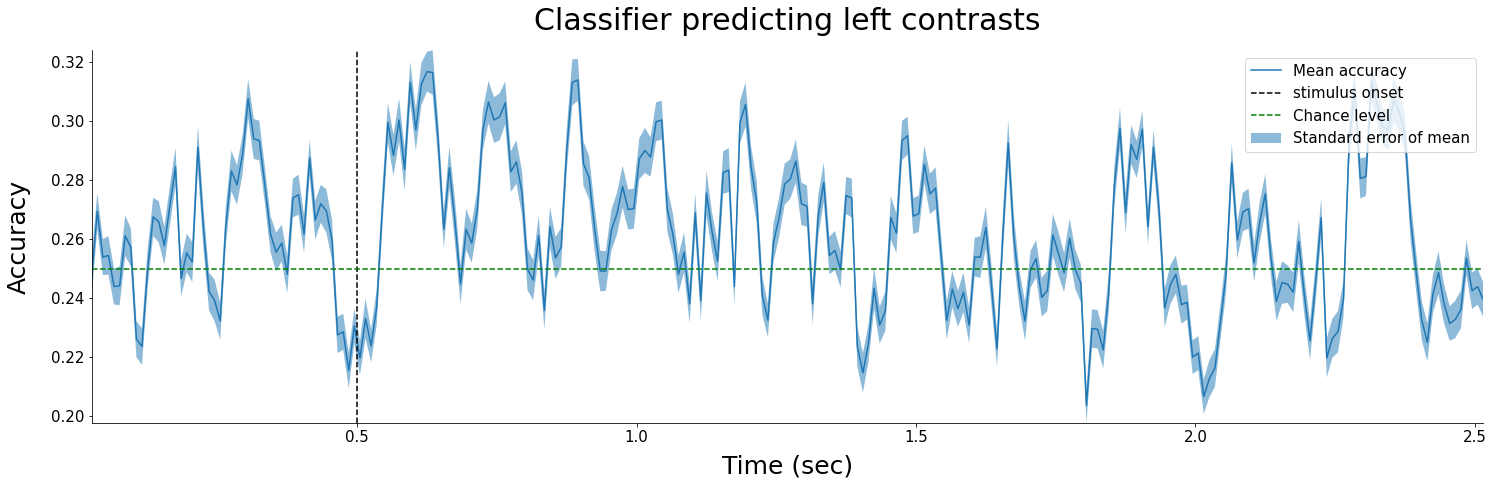

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(t+0.025, mean_left)
#ax.fill_between(t+0.025, (mean_left - std_left), (mean_left + std_left), alpha=.5, linewidth=0)
plt.fill_between(t+0.025, (mean_left - sem_left), (mean_left + sem_left), alpha=.5, linewidth=0)
plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
plt.axhline(y = 0.25, color = 'g', linestyle = '--', label = 'axhline - full height')
plt.legend(['Mean accuracy', 'stimulus onset', 'Chance level', 'Standard error of mean'], loc = 'upper right')
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Accuracy', fontsize = 25, labelpad = 20)
plt.title('Classifier predicting left contrasts', fontsize = 30, pad = 20)
plt.margins(0)

In [ ]:
y = response
x = windowed_spikes
scalers = {}
for i in range(x.shape[1]):
    scalers[i] = StandardScaler()
    x[:, i, :] = scalers[i].fit_transform(x[:, i, :])
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
x_res = np.zeros((276, 142, 250))
acc_resp = np.zeros((200,250))
for j in range(200):
  rus = RandomUnderSampler(random_state=j)
  for i in range(x.shape[1]):
    x_res[:, i, :], y = rus.fit_resample(x[:, i, :], y_transformed)
  X_train, X_test, y_train, y_test = train_test_split(x_res, y, test_size = 0.1, random_state=j, stratify=y)
  for i in range(X_train.shape[2]):
    svm_resp = SVC(kernel='rbf', decision_function_shape ='ovo')
    svm_resp.fit(X_train[:, :, i], y_train)
    y_pred = svm_resp.predict(X_test[:, :, i])
    acc_resp[j, i] = accuracy_score(y_test, y_pred)

In [ ]:
mean_resp = np.mean(acc_resp, axis = 0)
std_resp = np.std(acc_resp, axis = 0)
sem_resp = stats.sem(acc_resp)

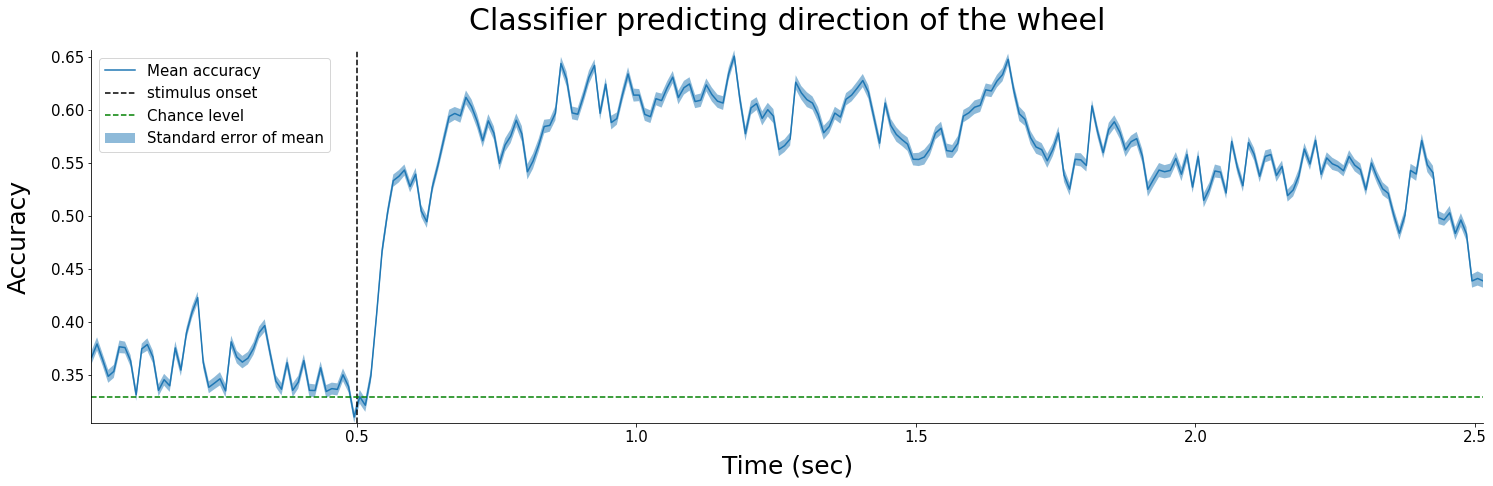

In [ ]:
ax = plt.subplots(figsize=(21, 7))
plt.plot(t+0.025, mean_resp)
#ax.fill_between(t+0.025, (mean_resp - std_resp), (mean_resp + std_resp), alpha=.5, linewidth=0)
plt.fill_between(t+0.025, (mean_resp - sem_resp), (mean_resp + sem_resp), alpha=.5, linewidth=0)
plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
plt.axhline(y = 0.33, color = 'g', linestyle = '--', label = 'axhline - full height')
#ax.set(ylabel='Accuracy', xlabel='time (s)', title='Classifier predicting direction of wheel')
plt.legend(['Mean accuracy', 'stimulus onset', 'Chance level', 'Standard error of mean'])
plt.xlabel('Time (sec)', fontsize = 25, labelpad = 10)
plt.ylabel('Accuracy', fontsize = 25, labelpad = 20)
plt.title('Classifier predicting direction of the wheel', fontsize = 30, pad = 20)
plt.margins(0)